In [108]:
import pandas as pd
import numpy as np

In [109]:
train_file = '../kaggle/titanic/train.csv'
test_file = '../kaggle/titanic/test.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Exploring Data

In [110]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Age vs Survived

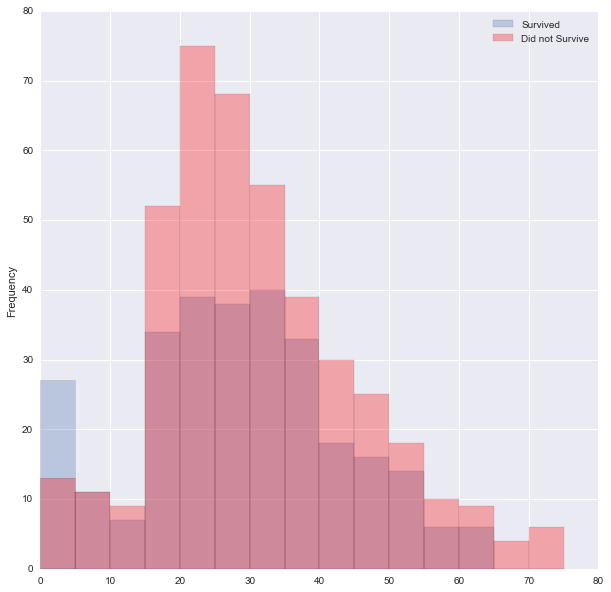

In [111]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
plt.figure(1)

bins_sizes = range(0,80,5)
train_data[train_data['Survived'] == 1]['Age'].plot(kind='hist',bins=bins_sizes, alpha=0.3, label='Survived',figsize = (10,10))

train_data[train_data['Survived'] == 0]['Age'].plot(kind='hist',bins=bins_sizes,alpha=0.3, color = 'r',label='Did not Survive').legend()


## Fare vs Survived

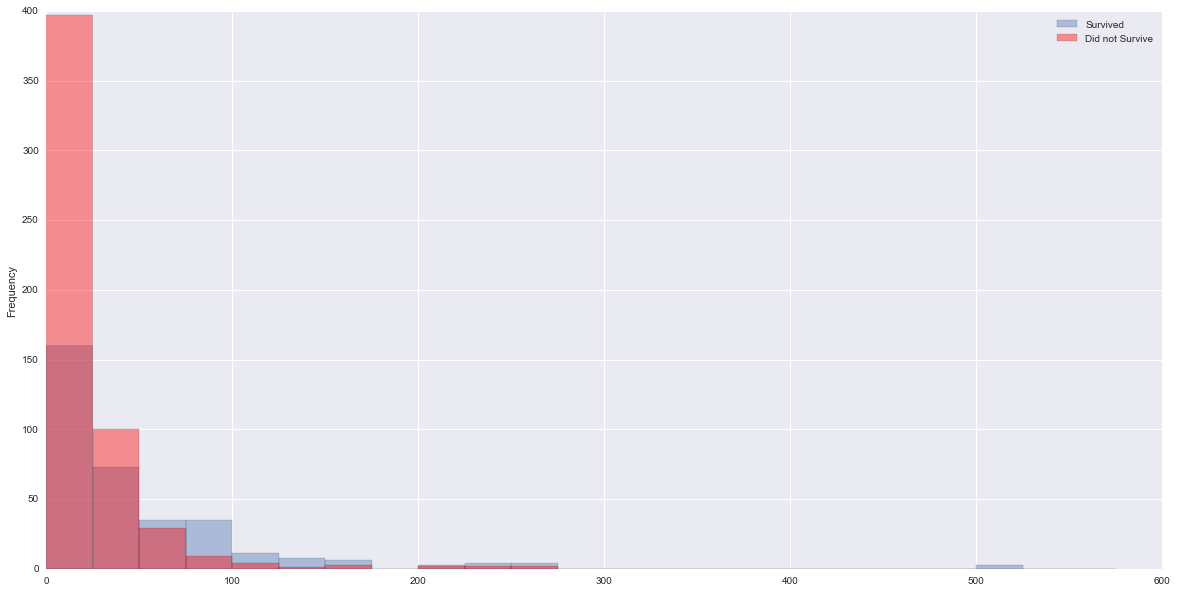

In [112]:
plt.figure(2)
bins_sizes = range(0,600,25)
train_data[train_data['Survived'] == 1]['Fare'].plot(kind='hist',bins=bins_sizes, alpha=0.4, label='Survived',figsize = (20,10))

train_data[train_data['Survived'] == 0]['Fare'].plot(kind='hist',bins=bins_sizes,alpha=0.4, color = 'r',label='Did not Survive').legend()


## Pclass vs Survived

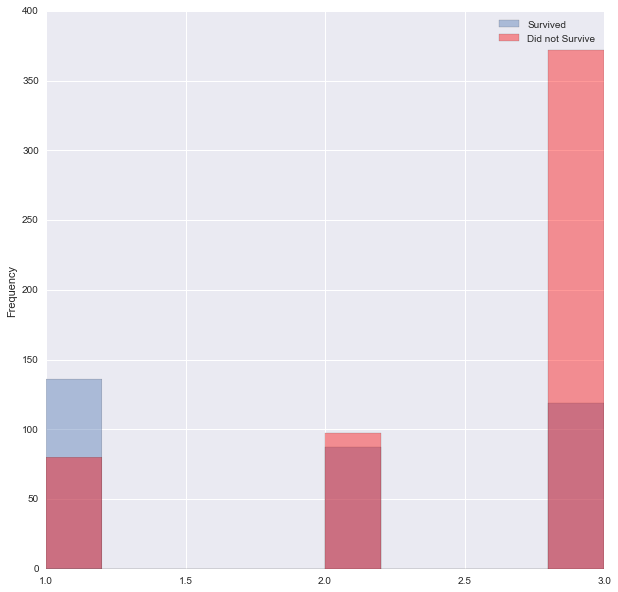

In [113]:
plt.figure(2)

train_data[train_data['Survived'] == 1]['Pclass'].plot(kind='hist', alpha=0.4, label='Survived',figsize = (10,10))

train_data[train_data['Survived'] == 0]['Pclass'].plot(kind='hist',alpha=0.4, color = 'r',label='Did not Survive').legend()


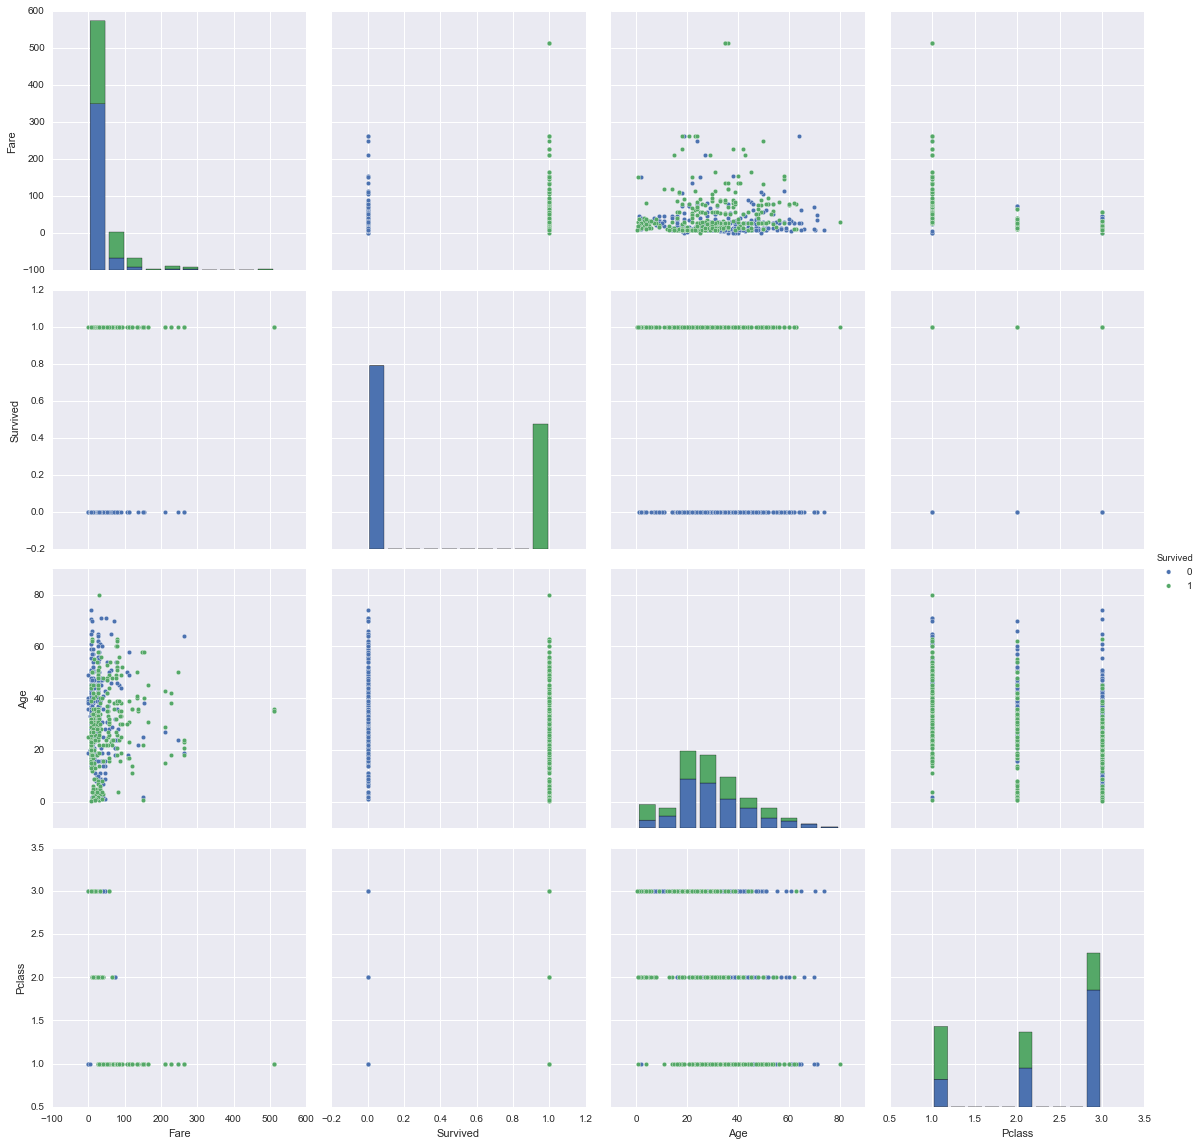

In [114]:
import seaborn as sns
plt.figure()
sns.pairplot(data=train_data[["Fare","Survived","Age","Pclass"]].dropna(),
             hue="Survived", size=4)

# Combining Train and Test sets for cleaning and feature generation

In [115]:
# Copy passengerID and Survived into df
survived = train_data[['PassengerId', 'Survived']]
train_data = train_data.drop('Survived', axis=1)

In [116]:
# Test train mask
train_data['train_set'] = 1
test_data['train_set'] =0

In [117]:
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_set
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [118]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_set
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [119]:
all_data = [test_data, train_data]
all_data = pd.concat(all_data)

In [120]:
print(all_data.shape, train_data.shape, test_data.shape)

(1309, 12) (891, 12) (418, 12)


# Cleaning and Creating Features

In [121]:
# Converting Sex into a binary variable
all_data['Gender'] = all_data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [122]:
#First we check which rows have NaN's in them
all_data.columns[pd.isnull(all_data).any()]
# .any() -> "Test whether any array element along a given axis evaluates to True."

Index(['Age', 'Fare', 'Cabin', 'Embarked'], dtype='object')

#### Age and how it correlated with other variables
Let's start with Age and look at a pair plot of Age along with Pclass, Sex and Fare. We can see that older people were in 1st class with younger people in 3rd class. 


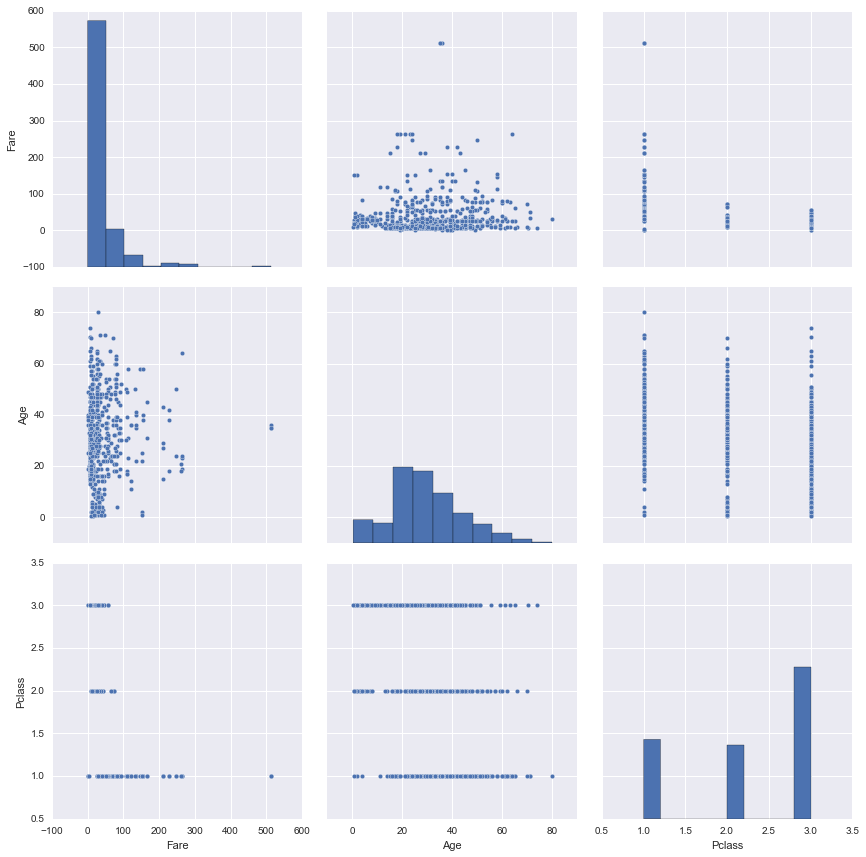

In [123]:
plt.figure()
sns.pairplot(data=train_data[["Fare","Age","Pclass"]].dropna(), size=4)

Lets impute NaN's for age with the median of people of the same gender in the same class. 

In [124]:
median_ages = np.zeros((2,3))
# We set the i's to be 0 for female and 1 for male.
# The j's are by class (1st, 2nd or 3rd)
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = all_data[(all_data['Gender'] == i) & \
                              (all_data['Pclass'] == j+1)]['Age'].dropna().median()



In [125]:
median_ages

array([[ 36. ,  28. ,  22. ],
       [ 42. ,  29.5,  25. ]])

In [126]:
median_ages[1,0] # Shows array indexing

42.0

In [127]:
def impute_age(row):
    if pd.isnull(row['Age']):
        return median_ages[row['Gender'],row['Pclass']-1]
    else:
        return row['Age']
    
all_data['Imputed_Age'] = all_data.apply(impute_age, axis=1)    

In [128]:
# Add a flag for rows that have had age imputed
def imputed_age_flag(row):
    if pd.isnull(row['Age']):
        return 1
    else:
        return 0


all_data['Imputed_age_flag'] = all_data.apply(imputed_age_flag, axis=1)

In [129]:
# Lets create a feature for family size
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch']

In [130]:
all_data.head(n=11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_set,Gender,Imputed_Age,Imputed_age_flag,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,34.5,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,47.0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,62.0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1,27.0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,22.0,0,2
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,1,14.0,0,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0,0,30.0,0,0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,1,26.0,0,2
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0,0,18.0,0,0
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,1,21.0,0,2


In [131]:
# Lets take a closer look at embarked...
all_data['Embarked'].unique()


array(['Q', 'S', 'C', nan], dtype=object)

In [132]:
# Lets get the dummies of the Embarked Variable
pd.get_dummies(data=all_data['Embarked'], prefix='embarked_')

,embarked__C,embarked__Q,embarked__S
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1
5,0,0,1
6,0,1,0
7,0,0,1
8,1,0,0
9,0,0,1


In [133]:
all_data = pd.concat([all_data, pd.get_dummies(data=all_data['Embarked'], prefix='embarked_')], axis=1)

In [134]:
all_data.head(n=15)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_set,Gender,Imputed_Age,Imputed_age_flag,FamilySize,embarked__C,embarked__Q,embarked__S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,34.5,0,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,47.0,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,62.0,0,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1,27.0,0,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,22.0,0,2,0,0,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,1,14.0,0,0,0,0,1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0,0,30.0,0,0,0,1,0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0,1,26.0,0,2,0,0,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0,0,18.0,0,0,1,0,0
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0,1,21.0,0,2,0,0,1


In [135]:
### Now we drop all the columns that don't contain numeric data that feeds into scikit learn
all_data.dtypes

PassengerId           int64
Pclass                int64
Name                 object
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
train_set             int64
Gender                int64
Imputed_Age         float64
Imputed_age_flag      int64
FamilySize            int64
embarked__C           uint8
embarked__Q           uint8
embarked__S           uint8
dtype: object

In [136]:
all_data = all_data.drop(['Name','Sex','Ticket','Cabin','Embarked','Age','Fare'], axis=1)

In [137]:
all_data.head()

,PassengerId,Pclass,SibSp,Parch,train_set,Gender,Imputed_Age,Imputed_age_flag,FamilySize,embarked__C,embarked__Q,embarked__S
0,892,3,0,0,0,1,34.5,0,0,0,1,0
1,893,3,1,0,0,0,47.0,0,1,0,0,1
2,894,2,0,0,0,1,62.0,0,0,0,1,0
3,895,3,0,0,0,1,27.0,0,0,0,0,1
4,896,3,1,1,0,0,22.0,0,2,0,0,1


In [138]:
# Now we join this with the 'Survived' column
all_data = pd.merge(all_data, survived, how='left',on='PassengerId')

In [139]:
all_data.head()

,PassengerId,Pclass,SibSp,Parch,train_set,Gender,Imputed_Age,Imputed_age_flag,FamilySize,embarked__C,embarked__Q,embarked__S,Survived
0,892,3,0,0,0,1,34.5,0,0,0,1,0,NaN
1,893,3,1,0,0,0,47.0,0,1,0,0,1,NaN
2,894,2,0,0,0,1,62.0,0,0,0,1,0,NaN
3,895,3,0,0,0,1,27.0,0,0,0,0,1,NaN
4,896,3,1,1,0,0,22.0,0,2,0,0,1,NaN


In [140]:
training_data = all_data[all_data['train_set'] == 1].drop(['train_set','PassengerId'], axis=1)

In [141]:
training_data = training_data.values

In [142]:
training_data

array([[ 3.,  1.,  0., ...,  0.,  1.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  1.],
       [ 3.,  0.,  0., ...,  0.,  1.,  1.],
       ..., 
       [ 3.,  1.,  2., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 3.,  0.,  0., ...,  1.,  0.,  0.]])

In [143]:
testing_data = all_data[all_data['train_set'] == 0].drop(['train_set','PassengerId','Survived'], axis=1)
print(testing_data.columns[pd.isnull(testing_data).any()]) #make sure no NaN's
testing_data = testing_data.values

Index([], dtype='object')


## Machine Learning on the Data

In [144]:
# Simple Random forest built on the entire dataset.
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100)


In [145]:
training_data[0::,1::]

array([[ 1.,  0.,  1., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       ..., 
       [ 1.,  2.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  1.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]])

In [146]:
forest = forest.fit(training_data[0:,:-1],training_data[0:,-1])

In [147]:
output = forest.predict(testing_data)

### Performing grid search and 5-fold CV on training data

In [148]:
from sklearn.model_selection import GridSearchCV

In [149]:
RF_parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[10, 100, 1000, 10000]}

In [ ]:
forest = RandomForestClassifier()
RF_gridsearch = GridSearchCV(forest, RF_parameters, cv=5, verbose=2)
RF_gridsearch_result = RF_gridsearch.fit(training_data[0:,:-1],training_data[0:,-1])

In [60]:
RF_gridsearch_result.best_estimator_ 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [61]:
RF_gridsearch_result.best_score_

0.79797979797979801

In [62]:
RF_gridsearch_result.best_params_

{'criterion': 'entropy', 'n_estimators': 100}

In [63]:
RF_gridsearch_result.n_splits_

5

In [64]:
RF_gridsearch_result.best_estimator_.feature_importances_

array([ 0.11910738,  0.04043343,  0.03493768,  0.26044319,  0.40573102,
        0.02197961,  0.07092646,  0.01600762,  0.00998783,  0.02044578])

In [66]:
all_data[all_data['train_set'] == 0].drop(['train_set','PassengerId','Survived'], axis=1).columns

Index(['Pclass', 'SibSp', 'Parch', 'Gender', 'Imputed_Age', 'Imputed_age_flag',
       'FamilySize', 'embarked__C', 'embarked__Q', 'embarked__S'],
      dtype='object')

In [67]:
feature_importances = pd.DataFrame(RF_gridsearch_result.best_estimator_.feature_importances_, index=all_data[all_data['train_set'] == 0].drop(['train_set','PassengerId','Survived'], axis=1).columns)

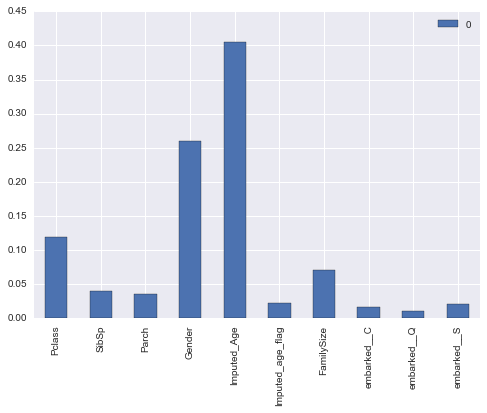

In [72]:
feature_importances.plot(kind = 'bar')